This tutorial is a continuation of the "from scratch" series we started last time with [the blog post] demonstrating the implementation of a simple k-nearest neighbors algorithm. The machine learning model we will be looking at today is logistic regression. If the "regression" part sounds familiar, yes, that is because logistic regression is a close cousin of [linear regression]---both models are employed in the context of regression problems. Linear regression is used when the estimation parameter is a continuous variable; logistic regression is best suited to tackle [binary classification] problems. Implementing the logistic regression model is slightly more challenging due to the mathematics involved in gradient descent, but we will make every step explicit throughout the way. Without further ado, let's get into it.


# The Logistic Function

To understand the clockwork behind logistic regresssion, it is necessary to understand the [logistic function]. Simply put, the logistic function is a s-shaped curve the squishes real values between positive and negative infinity into the range $[0, 1]$. This property is convenient from a machine leanring perspective because it allows us to perform binary classification. Binary classification is a type of classification problem where we are assigned the task of categorizing data into two groups. For instance, given the dimensions of a patient's tumor, determine whether the tumor is malignant or benign. Another problem might involve classifying emails as either spam or not spam. We can label spam emails as 1 and non-spam emails as 0, feed the data into a predefined machine learning algorithm, and generate predictions using that model. If the output of an algorithm given some data point is larger than 0.5, it is likely that the given input is a spam; if it is smaller than the 0.5 threshold, chances are the email is not spam. 

Let's take a look at the shape of the sigmoid function, which is a special case of the logistic function that we will use throughout this post. To plot the sigmoid function, we need to import some libraries.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

The sigmoid function is defined as follows:

$$S(x) = \frac{1}{1 + e^{-x}}$$

We can express this as a Python function, as demonstrated in the code snippet below.

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

Let's quickly plot the graph to see what the sigmoid function looks like.

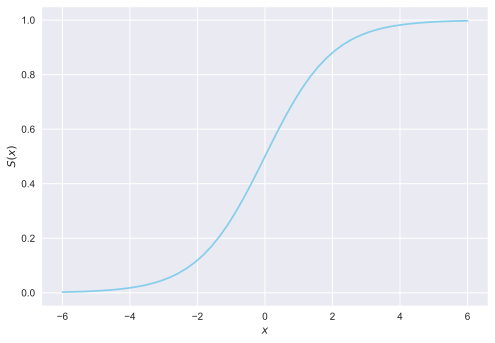

In [3]:
x = np.linspace(-6, 6)
y = sigmoid(x)

plt.plot(x, y, color="skyblue")
plt.xlabel("$x$"); plt.ylabel("$S(x)$")
plt.show()

As we can see, the sigmoid is a smooth, differentiable function that is bounded between 0 and 1. It is also symmetrical around the point $(0, 0.5)$, which is why we can use 0.5 as a threshold for determining the class of a given data point. 

The logistic regression model uses the sigmoid function to generate predictions, but how exactly does it work? Recall that, in the case of linear regression, our goal was to determine the coefficients of some linear function, specifically 

$$h(x) = \theta_0 + \theta_1 x_1 + \theta_1 x_2 + \cdots + \theta_n x_n = \theta^T x \tag{1}$$

Logistic regression is not so different from linear regression. In fact, we can borrow the same notation we used for linear regression to frame logistic regression as follows:

$$S(h(x)) = \frac{1}{1 + e^{-(\theta_0 + \theta_1 x_1 + \theta_1 x_2 + \cdots + \theta_n x_n})} = \frac{1}{1 + e^{-\theta^T x}} \tag{2}$$

In other words, logistic regression can be understood as a process in which our goal is to find the weight coefficients in the equation above the best describe the given data set. Unlike in linear regression, where the predicted value is computed simply by passing the data as arguments into a linear function, logistic regression outputs numbers between 0 and 1, making binary classification possible. However, there is certainly an element of linearity involved, which is part of the reason why both linear and logistic regression models fall under a larger familiy of models called [generalized linear models].

Now that we know the basic maths behind logistic regression using the sigmoid function, it's time to implement it via code.

# Building the Logistic Regression Model

Welcome to the next part of the tutorial, where we start building the actual model from scratch. As always, it's a good idea to have some dummy data ready for disposal so that we can develop some basic intuition about dimensionality of our data when handling inputs and outputs of our functions. Here is the data we used in the last post on k-nearest neighbors algorithm, slightly modified for the purposes of this post.

In [4]:
toy_dataset = [[2.7810836,2.550537003,1],
           [1.465489372,2.362125076,1],
           [3.396561688,4.400293529,1],
           [1.38807019,1.850220317,1],
           [3.06407232,3.005305973,1],
           [7.627531214,2.759262235,1],
           [5.332441248,2.088626775,1],
           [6.922596716,1.77106367,1],
           [8.675418651,-0.242068655,1],
           [7.673756466,3.508563011,1]]
label = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

## The Sigmoid Function

Let's start by translating equation (2) into executable code. The idea is that we want to get a dot product of the weight vector and the data vector, then plug the resulting value into the sigmoid function to get some value between 0 and 1. The `make_prediction` function shown below exactly performs this task, with the added caveat that it returns a label prediction when the boolean argument `classify` is set to `True`; a raw sigmoid output when the same is set to `False`. 

In [5]:
def make_prediction(w, x, classify=False):
    z = sigmoid(np.dot(w, x))
    if classify:
        return int(z > 0.5)
    else:
        return z

Let's perform a quick sanity check by using some dummy weight vector. Using the coefficients in the `weight` list, we can generate predictions for each observation in the `toy_dataset`. 

In [6]:
weight = [-0.4, 0.9, -2]
prediction = []
for data in toy_dataset:
    prediction.append(make_prediction(weight, data, classify=True))
prediction

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

The actual class information is stored in the `label` list.

In [7]:
label

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

The dummy coefficients are poorly optimized, which is why the predicted class labels do not align well with the actual class labels. This tells us that more tuning is required to update the coefficients and build a robust logistic regression model. 

But how exactly can we tune our model? Simply eyeballing the actual and predicted labels of our data is probably not going to help us much. To optimize the coefficients to best fit our data, we need to construct some loss function---that is, a function that describes how badly our model is performing. Then, we can optimize the weights of our model by minimizing that loss function, which would mean that our model gradually makes better predictions with each round of optimization. 

## Cross Entropy Loss Function

If you recall the [previous post] on entropy, you will remember that we discussed a concept called [cross entropy]. In that post, we derived the formula for cross entropy and intuitively understood it as a way of measuring the "distance" between two distributions. This is exactly what we need: a way of quantifying how different the actual and predicted class labels are! Recall the formula for cross entropy:

$$H(p, q) = - \sum_{i = 1}^n p(x_i) \log(q(x_i)) \tag{3}$$

We can consider class labels as a Bernoulli distribution where data that belongs to class 1 has probability 1 of belonging to that class 1 and probabiliy 0 of belonging to class 0, and vice versa for observations in class 0. The logistic regression model will output a Bernoulli distribution, such as $[0.6, 0.4]$, which means that the given input has a 60 percent chance of belonging to class 1; 40 percent to class 0. Applying this to (3), we get:

$$H(y, \hat{y}) = - \sum_{i = 1}^n y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \tag{4}$$

And that is the loss function we will use for logistic regression! The reason why we have two terms, one involving just $y$ and another involving $1 - y$ is due to the structure of the Bernoulli distribution, which by definition can be written as

$$f(k; p) = pk + (1 - p)(1 - k) \, \text{for } k \in {0, 1}$$

Now that we have a loss function to work with, let's build a function that computes cross entropy loss given `y_true` and `y_pred` using (4).


In [8]:
def cross_entropy(y_true, y_pred):
    data_num = len(y_true)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total = - np.sum(np.multiply(y_true, np.log(y_pred)) + np.multiply((1 - y_true), np.log(1 - y_pred)))
    return total / data_num

The `cross_entropy` function returns the average cross entropy over all input data. We use average cross entropy instead of total cross entropy, because it doesn't make sense to penalize the model for high cross entroy when the input data set was large to begin with.

## Gradient Descent

Now what's next? Since we have a loss function, we need to build an algorithm that will allow us to minimize this cost function. One of the most common methods used to achieve cost minimization is [gradient descent]. As you might be able to tell, this algorithm has a lot to do with gradients, which can loosely be understood as a fancy way of saying derivatives. Below is an illustration of the gradient descent algorithm in action.

<img src="/assets/images/gradient-descent.svg">

Basically, what gradient descent does is that it takes the derivative of the loss function with respect to the weight vector every epoch, or iteration, and takes a small step in the opposite direction of that derivative. If you think of this in the context of two dimensions as shown in the illustration, the gradient descent algorithm ends up moving down the parabola, taking little steps each time, until it eventually reaches the global minimum. In mathematical notation, we might express this process as follows:

$$\theta_i := \theta_i - \alpha \frac{\partial H}{\partial \theta_i} \tag{5}$$

If we were to perform this in vectorized format, 

$$\theta := \theta - \alpha \nabla_\theta H \tag{6}$$

where $\theta$ represents a vector containing the weight coefficients of the logistic regression model:

$$\theta = \begin{pmatrix} \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{pmatrix}$$

The $\nabla$ notation is used to denote gradients, an important operation in matrix calculus which we explored in when deriving the normal equation solution to [linear regression] on this blog. The $\alpha$ denotes a hyperparamter known as the learning rate, which essentially determines how big of a step the gradient descent model takes with each iteration. The main takeaway here is the the gradient descent method allows us to find the local minimum of any convex function, no matter how multidimensional or complex. This is an incredibly powerful statement, and it is one that lies at the core of many machine learning algorithms. 

To implement gradient descent with code, we have to figure out what the gradient descent equation is in the case of logistic regression. To do this, we need a bit of calculus work using the chain rule. Recall that our goal is to compute

$$\nabla_\theta H = \begin{pmatrix} \frac{\partial H}{\partial \theta_1} \\ \frac{\partial H}{\partial \theta_2} \\ \vdots \\ \frac{\partial H}{\partial \theta_n} \end{pmatrix}$$

since we want to calculate the slope of the cross entropy function with respect to the weights vector. For notational convenience, let's denote the gradient as a derivative:

$$\nabla_\theta H = \frac{\partial H}{\partial \theta} \tag{7}$$

The gradient in (7) can be broken down into distinct components via the chain rule:

$$\frac{\partial H}{\partial \theta} = \frac{\partial H}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z} \frac{\partial z}{\partial \theta} \tag{8}$$

where 

$$\begin{align} z &= \theta^T x , & \hat{y} &= S(z) \end{align} \tag{9}$$

So the task of calculating the gradient now boils down to finding the derivative for each of the terms shown in (8). Let's start with the easiet one, the last term, which is the derivative of $z$ with respect to $\theta$. From (9), we can conclude that

$$\frac{\partial z}{\partial \theta} = x \tag{10}$$

The next in line is the derivative of the sigmoid function, which goes as follows:

$$\begin{align*} \frac{\partial \hat{y}}{\partial z} &= \frac{\partial} {\partial z}\left( \frac{1}{1 + e^{-z}} \right) \\ &= (1 + e^{-z})^{-2} e^{-z} \\ &= \frac{1}{1 + e^{-z}} \frac{e^{-z}}{1 + e^{-z}} \\ &= \hat{y}(1 - \hat{y}) \end{align*} \tag{11}$$

Now we are almost there. The last piece of the puzzle is computing the first term in (8), the derivative of the cross entropy function. 

$$\begin{align*} \frac{\partial H}{\partial \hat{y}} &= - \frac{\partial}{\partial \hat{y}} \left(y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \right) \\ &= \frac{1 - y}{1 - \hat{y}} - \frac{y}{\hat{y}} \end{align*} \tag{12}$$ 

Putting this all together into (8), we get:

$$\begin{align*} \frac{\partial H}{\partial \theta} &= \frac{\partial H}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z} \frac{\partial z}{\partial \theta} \\ &= \left( \frac{1 - y}{1 - \hat{y}} - \frac{y}{\hat{y}} \right) \hat{y}(1 - \hat{y}) x \\ &= (\hat{y} - y)x \end{align*} \tag{13}$$

Voila! We have derived an expression for the gradient of the cross entropy loss function. There is one more tiny little step we have to make to concretize this equation, and that is to consider the average of the total gradient, since (13) as it stands applies to only one data observation. 

$$\frac{\partial H}{\partial \theta}_{avg} = \frac{1}{n} \sum_{i = 1}^n (\hat{y} - y)x \tag{14}$$

Granted, this derivation is not meant to be a rigorous demonstration of mathematical proof, because we glossed over some details concerning matrix tranposes, dot products, and dimensionality. Still, it provides a solid basis for the construction of the gradient descent algorithm in code, as shown below.

In [9]:
def gradient_descent(alpha, epoch, weight, X, y, threshold, print_option=True, get_cost=False):
    y_pred = np.array([make_prediction(weight, x) for x in X])
    data_num = len(y)
    cost = []
    for i in range(epoch):
        dw = np.dot((y_pred - y), X) / data_num
        weight = weight - alpha * dw
        y_pred = np.array([make_prediction(weight, x) for x in X])
        new_cost = cross_entropy(y, y_pred)
        cost.append(new_cost)
        if print_option and i%50==0: print("Iteration {0}, Cost: {1}".format(i, new_cost))
        if i > 3 and cost[-2] - cost[-1] < threshold:
            break
    if get_cost:
        return cost
    else:
        return weight

To avoid compensating code readability, I made a stylistic choice of using `w` and `weight` to denote the vector of coefficients instead of using `theta` for notational consistency. Other than adding some switch optional parameters such as `print_option` or `get_cost`, the code simply follows the gradient descent algorithm outlined above. Note that equation (6) is expressed via `weight = weight - alpha * dw`; equation (14) is expressed by the line `dw = np.dot((y_pred - y), X) / data_num`. 

Let's quickly check that the `gradient_descent` function works as expected using the dummy data we created earlier.


In [10]:
gradient_descent(0.1, 200, weight, toy_dataset, label, 0.0001)

Iteration 0, Cost: 1.182528373826317
Iteration 50, Cost: 0.1306481850308255
Iteration 100, Cost: 0.07491036607639494
Iteration 150, Cost: 0.053585058580496114


array([ 1.45236701, -1.44043889, -2.5655978 ])

Great! We see that the average cross entropy decreases with more iterations. The returned `numpy` array contains the coefficients of the logistic regression model, which we can use to now make predictions. 

We can stop here, but just like we did in the post on k-nearest neighbors, let's wrap all the functions we have created so far into a single function that represents the logistic regression model.

In [11]:
def logistic_regression(training_set, label, test_set, alpha, epoch, threshold=0.0001, print_option=False, get_cost=False):
    weight = np.random.rand(len(training_set[0]))
    if get_cost:
        cost = gradient_descent(alpha, epoch, weight, training_set, label, threshold, print_option, get_cost)
        return cost
    else:
        new_weight = gradient_descent(alpha, epoch, weight, training_set, label, threshold, print_option)
        prediction = [make_prediction(new_weight, instance, classify=True) for instance in test_set]
        return np.array(prediction)

Our model is ready. Time for testing with some real-world data.

# Testing the Model

Let's import some data from the web. The data we will be looking at is the banknote authentification data set, publicly available on the [UCI Machine Learning Repository]. This data set contains 1372 observations of bank notes, classsified as either authentic or counterfeit. The five features columns of this data set are:

* Variance of Wavelet Wavelet Transformed image (Continuous) 
* Skewness of Wavelet Transformed image (Continuous) 
* Curtosis of Wavelet Transformed image (Continuous) 
* Entropy of image (Continuous) 
* Class (Binary integer) 

Let's use some modules to import this data set onto our notebook, as shown below.



In [12]:
from numpy import loadtxt
from urllib.request import urlopen
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
raw_data = urlopen(url)
dataset = loadtxt(raw_data, delimiter=",")
X, y = np.array([np.append(x, 1) for x in dataset[:,:-1]]), dataset[:, -1]

The imported data set was slightly modified in two ways to fit our model. First, I separated the class label data from the data set and stored it as a separate `numpy` array. Second, I appended `1`s to each observation to create a new column that accounts for intercept approximation. All this means is that we consider our linear model to be

$$h(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_1 x_2 + \cdots + \theta_n x_n = \theta^T x \tag{1}$$

where 

$$x_0 = 1$$

for all available sample observations. This is something that we have been assuming all along throughout the gradient descent derivation process, but had not been stated explicitly to reduce confusion. Just consider it a strategic choice on our part to simplify the model while allowing for the logistic regression model to consider bias. 

Let's check the shape of the imported data set to check that the data has been partitioned correctly.


In [13]:
X.shape

(1372, 5)

In [14]:
y.shape

(1372,)

Now, it's time to split the data into training and testing data. To do this, I recycled a function we built earlier in the previous post on k-nearest neighbors algorithm. 

In [15]:
def my_train_test_split(X, y, test_size, random_state):
    data_num = len(y)
    test_num = int(test_size * data_num)
    np.random.seed(random_state)
    index = np.random.permutation(data_num)
    X_train = X[index[:-test_num]]
    X_test = X[index[-test_num:]]
    y_train = y[index[:-test_num]]
    y_test = y[index[-test_num:]]
    return X_train, X_test, y_train, y_test

Using `my_train_test_split`, we can partition the data set into training and testing data. Let's make 20 percent of observations as testing data and allocate the rest for training.

In [16]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y, 0.2, 42)

It's time for some training and prediction generation. Because we did all the work in the previous section, training and predicting can be achieved with just a single line of command. To see how quickly average cross entropy is decreasing, I turned on the `print_option` as true. This way, we can see how quickly the loss is declining over every 50 epochs. 

In [17]:
y_pred = logistic_regression(X_train, y_train, X_test, 0.1, 1000, threshold=0.00001, print_option=True)

Iteration 0, Cost: 1.8645873915204194
Iteration 50, Cost: 0.12724295853835318
Iteration 100, Cost: 0.09500780070378237
Iteration 150, Cost: 0.08051200520236851
Iteration 200, Cost: 0.07152813537793914
Iteration 250, Cost: 0.06521190357551303
Iteration 300, Cost: 0.06046029372003293
Iteration 350, Cost: 0.0567287055259228
Iteration 400, Cost: 0.05370806680847458
Iteration 450, Cost: 0.05120649109874576
Iteration 500, Cost: 0.04909714872119953
Iteration 550, Cost: 0.047292239538382304
Iteration 600, Cost: 0.045728769034644075
Iteration 650, Cost: 0.04436022796651144
Iteration 700, Cost: 0.04315146064694956
Iteration 750, Cost: 0.042075362704003874
Iteration 800, Cost: 0.041110680842644444
Iteration 850, Cost: 0.04024050353492443
Iteration 900, Cost: 0.0394511996919855
Iteration 950, Cost: 0.038731656216495214


It's now time to see how well our model has done. Let's compare `y_pred`, the list that contains the model's predictions, with `y_test`, which is essentially the answer key.

In [18]:
dictionary = {}
for boolean in y_pred == y_test:
  if boolean in dictionary:
    dictionary[boolean] += 1
  else:
    dictionary[boolean] = 1
  
dictionary

{True: 272, False: 2}

This is great news. The result shows us that we have correctly predicted 272 values while making wrong predictions in only 2 cases. Let's systematize this quantity by creating a `accuracy_score` function that returns how accurate our model is given `y_true` and `y_pred`.

In [19]:
def accuracy_score(y_true, y_pred):
    count = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            count += 1
    return count/len(y_true)

Let's use this function to test how well our model performed.

In [20]:
accuracy_score(y_pred, y_test)

0.9927007299270073

99 percent is not a bad estimate at all. One interesting question to consider is how much boost in accuracy we see with each epoch, *i.e.* what is the bang-per-buck of each iteration cycle? This is an important question to consider because gradient descent is computationally expensive; if we can train our model in just 10 epochs instead of 1000, why not choose the former? To answer this question, let's plot accuracy against epoch. For fun, I added the learning parameter `alpha` as an argument to the `plot_accuracy` function as well. 

In [21]:
def plot_accuracy(alpha, epoch):
    accuracy = []
    iter_range = range(epoch)
    for iter_num in iter_range:
        y_hat = logistic_regression(X_train, y_train, X_test, alpha, iter_num)
        accuracy.append(accuracy_score(y_hat, y_test))
    plt.plot(iter_range, accuracy, color="skyblue")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.show()

Let's create a plot to see how accuracy changes over 200 epochs, given a learning rate of 0.1. 

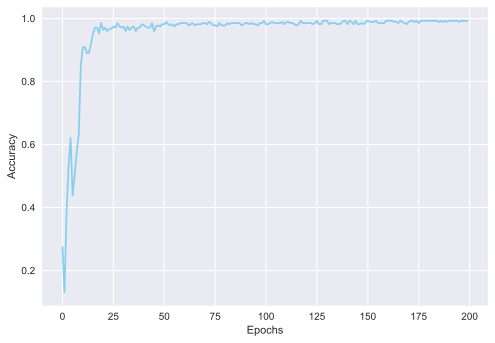

In [22]:
plot_accuracy(0.1, 200)

We see that accuracy spikes up on the first 20- epochs or so and quite quickly converges to about 90 percent. Past a certain threshold, the model seems to hover consistently at aroud the high 90s range, but accuracy still continues to increase ever so slightly with each epoch, though not as quickly as before. 

If we set the learning rate `alpha` to a smaller number, we would expect the model to take a lot longer to tune, and indeed this seems to be true:

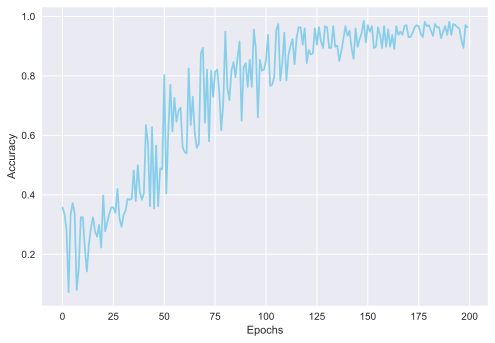

In [23]:
plot_accuracy(0.01, 200)

With a much smaller learning rate, the model seems to struggle to achieve high accuracy. However, although there are a lot of uneven spikes, the model still manages to reach a pretty high accuracy score by 200 epochs. This tells us that the success of model training depends a lot on how we set the learning rate; setting an excessively high value for the learning rate might result in overshooting, while a low learning rate might prevent the model from quickly leanring from the data and making meaningful progress.

Accuracy helps us intuitively understand how well our model is doing, but recall that the main objective of gradient descent is not to maximize accuracy, but to minimize the cross entropy loss function. Therefore, perhaps it makes more sense to evaluate the performance of our logistic regression model by plotting cross entropy. Presented below is a simple function that plots epoch versus cross entropy given a list of learning rates, `alpha`.

In [24]:
def plot_loss(alpha, epoch):
    for rate in alpha:
        cost = logistic_regression(X_train, y_train, X_test, rate, epoch, threshold=0.00001, get_cost=True)
        iter_num = range(len(cost))
        plt.scatter(iter_num, cost, label=r'$\alpha$ = {0}'.format(rate))
    plt.xlabel("Number of Iterations"); plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.show()

Let's plot cross entropy loss for three different values of `alpha`: 0.05, 0.1, and 0.5. Just like before, we cap the number of iterations to 200 epochs.

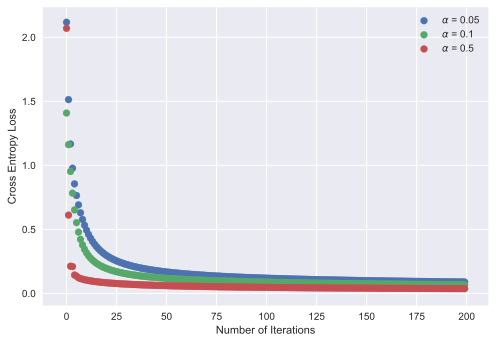

In [25]:
epoch = 200
alpha_lst = [0.05, 0.1, 0.5]
plot_loss(alpha_lst, epoch)

The graph shows that the larger the learning rate, the quicker the decrease in cross entropy loss. This result is coherent with what the previous visualizations on accuracy suggested: the higher the learning rate, the quicker the model learns from the training data. 

# Conclusion

In this post, we built the logistic regression model from scratch by deriving an equation for gradient descent on cross entropy given a sigmoid function. In the process, we brought together many useful concepts we explored on this blog previously, such as matrix calculus, cross entropy, and more. It's always exciting to see when seemingly unrelated concepts come together to form beautiful pictures in unexpected ways, and that is what motivates me to continue my journey down this road.

The logistic regression model is simple yet incredibly powerful in the context of binary classification. As we saw earlier with the application of the model to the task of bank notes authentification, the logistic regression model can, when tweaked with the appropriate parameters, make surprisingly accurate predictions given sufficient amount of training data. Of course, the processing of training and tweaking is not always easy because we have to determine some hyperparameters, most notably the learning rate of the gradient descent algorithm, but the fact that logistic regression is a robust model is unchanged nonetheless. Hopefully this post gave you some idea of what happens behind the scene in a regression-based machine learning model.

Thanks for reading. See you in the next post!



[the blog post]: https://jaketae.github.io/study/KNN/
[logistic function]: https://en.wikipedia.org/wiki/Logistic_function
[linear regression]: https://jaketae.github.io/study/linear-regression/
[binary classification]: https://en.wikipedia.org/wiki/Binary_classification
[generalized linear models]: https://en.wikipedia.org/wiki/Generalized_linear_model
[previous post]: https://jaketae.github.io/study/information-entropy/
[cross entropy]: https://en.wikipedia.org/wiki/Cross_entropy
[UCI Machine Learning Repository]: https://archive.ics.uci.edu/ml/datasets/banknote+authentication
[gradient descent]: https://en.wikipedia.org/wiki/Gradient_descent